# Utilisation des graphes pour la détection de plastique dans les océans.

This notebook presents the use of spectral clustering fo plastic detection. This method is based on the use of mathematical graphs to create clusters. More information here : https://towardsdatascience.com/spectral-clustering-aba2640c0d5b

In [1]:
## Importations

import os 
import tifffile
import numpy as np
import sklearn
from sklearn.cluster import KMeans , SpectralClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy
import time
from scipy.spatial import distance

In [2]:
## get an array from the multispectral image sentinel 2
def get_array(folder):
    # we want all the bands to create the dataset
    L = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']
    path = 'data/'+ folder
    inside_folder = os.listdir(path)

    # store the bands
    #band_array = np.zeros((600,1400,len(L)))
    band_array = np.zeros((84,183,len(L)))
    ## load wanted spectral bands
    i = 0
    for raw_band in inside_folder:
        for desired_band in L:
            if desired_band in raw_band:
                img = tifffile.imread(os.path.join(path,raw_band))
                # crop the image not to have problems when creating patchs
                #band_array[:,:,i] = img[:600,:1400]
                band_array[:,:,i] = img
                i+=1
    return band_array


def scale(img):
    result = np.zeros(img.shape).astype('float32')
    for band in range(img.shape[2]):
        mean = float(np.mean(img[:,:,band]))
        std = float(np.std(img[:,:,band]))
        print(std)
        result[:,:,band] = (img[:,:,band] - mean)/std
    return(img)
        

## perform PCA
def perform_pca(X,n):
    pca = PCA(n_components=n, whiten = False)
    Xpca = pca.fit_transform(X )
    return(Xpca)

# Sentinel 2 image


## Image preprocessing 

During the studies, we found that cluterings algorithms were ineffective when land could be fount on the image : the problem with unsupervised methods is that we need to specify the number of clusters. In a spatial image, plastic waste will never be considered as a cluster if there is too much "things" (ex : water and land, or water, land and forest etc...). We tried here to remove land pixels by simply replacing them by water pixels. This way, we tried to have a "fake" image with only water and plastic. We need to be careful about the cost whiwh may not be well segmentated because of the high resolution.

In [3]:
## get the sentinel 2 image, and take only the wanted spectral bands.
img = get_array('2019_04_18_M/')[:,:,[1,2,3,7]]

In [4]:

## kmeans function to perform clustering on an image
def kmeans(arrays, nb_clust):
    arrays_flat=np.array([arrays[:,:,i].flatten() for i in range(arrays.shape[2])])
    X=(np.transpose(arrays_flat))
    kmeans = KMeans(n_clusters=nb_clust,  init='k-means++', n_init=10, max_iter=1000) # tester k-means méthod max?
    kmeans.fit(X)
    labels=kmeans.labels_
    clust = kmeans.cluster_centers_
    plastic_index = 0
    nb = 99999
    nb_2 = 0
    img_labels = labels.reshape(arrays[:,:,0].shape)
    #img_labels = labels.reshape(84,183)
    
    #plt.figure()
    #plt.imshow(img_labels)
    #plt.title('labels after kmeans')
    
    return img_labels,clust


## delete land on an image (clustering and replace the values of pixels by a "water pixel")
def delete_land(img):
    labels,clust = kmeans(img, 2)
    ## signatures taken from a PLP image
    spectral_sign = {'water': [ 0.10384066, 0.13632251, 0.16474463, 
       0.3045134], 'ground':[ 0.03796409, 0.03244987, 0.02011696, 0.01891139]
                    ,'plastic' : [0.03825 , 0.037625, 0.0334 , 0.055125]}
    d1 = distance.euclidean(clust[0], spectral_sign['ground'])
    d2 = distance.euclidean(clust[1], spectral_sign['ground'])
    ground_label = 100
     
    if d1<d2:
        ground_label = 1
    else : 
        ground_label = 0
        
    result = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if labels[i,j] == ground_label :
                result[i,j] = spectral_sign['water']
                #result[i,j+1] = spectral_sign['water']
                #result[i,j+2] = spectral_sign['water']

    plt.figure()  
    
    plt.imshow(result[:,:,0])
    plt.title('result')
    return result

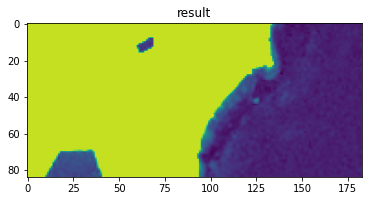

In [5]:
result0 = delete_land(img)
result = result0.copy()
#result = scale(result)


Now we need to flatten the image, as clustering algorithms do not take images as input but only vector [individual]_i in N where N is the number for pixels

In [6]:
## flatten the image
arrays_flat=np.array([result[:,:,i].flatten() for i in range(result.shape[2])])
X =(np.transpose(arrays_flat))

Another weel known method of preprocessing, that works well with images, is PCA. The idea is to keep only the most relevant information. However, it does not improve the results.

In [7]:
#X = perform_pca(X,0.8)

Now we can perform the spectral clustering algorithm, with 2 as the number of clusters :

In [8]:
start = time.time()
nb_cluster = 2
clustering0 = SpectralClustering(n_clusters=nb_cluster, n_components = 10, affinity = 'nearest_neighbors' ,  n_neighbors = 150).fit(X)
img_labels0 = clustering0.labels_.reshape(result[:,:,0].shape)
stop = time.time()
training_time = stop - start 
print('time : ', training_time ,'s')

C:\Users\basil\Anaconda3\envs\imsat\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


time :  8.79204797744751 s


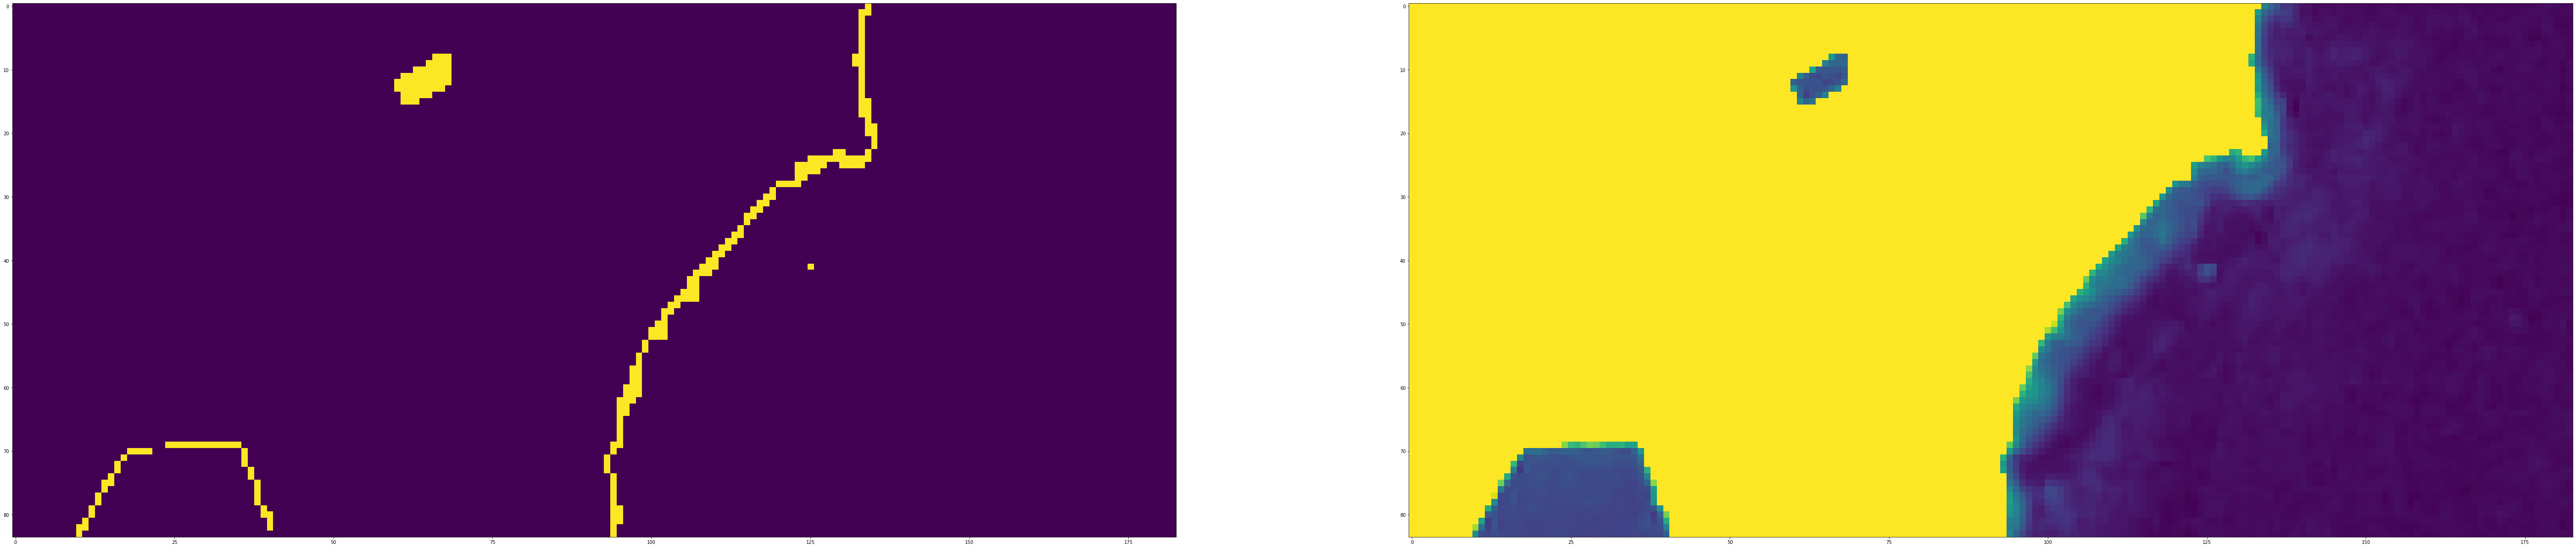

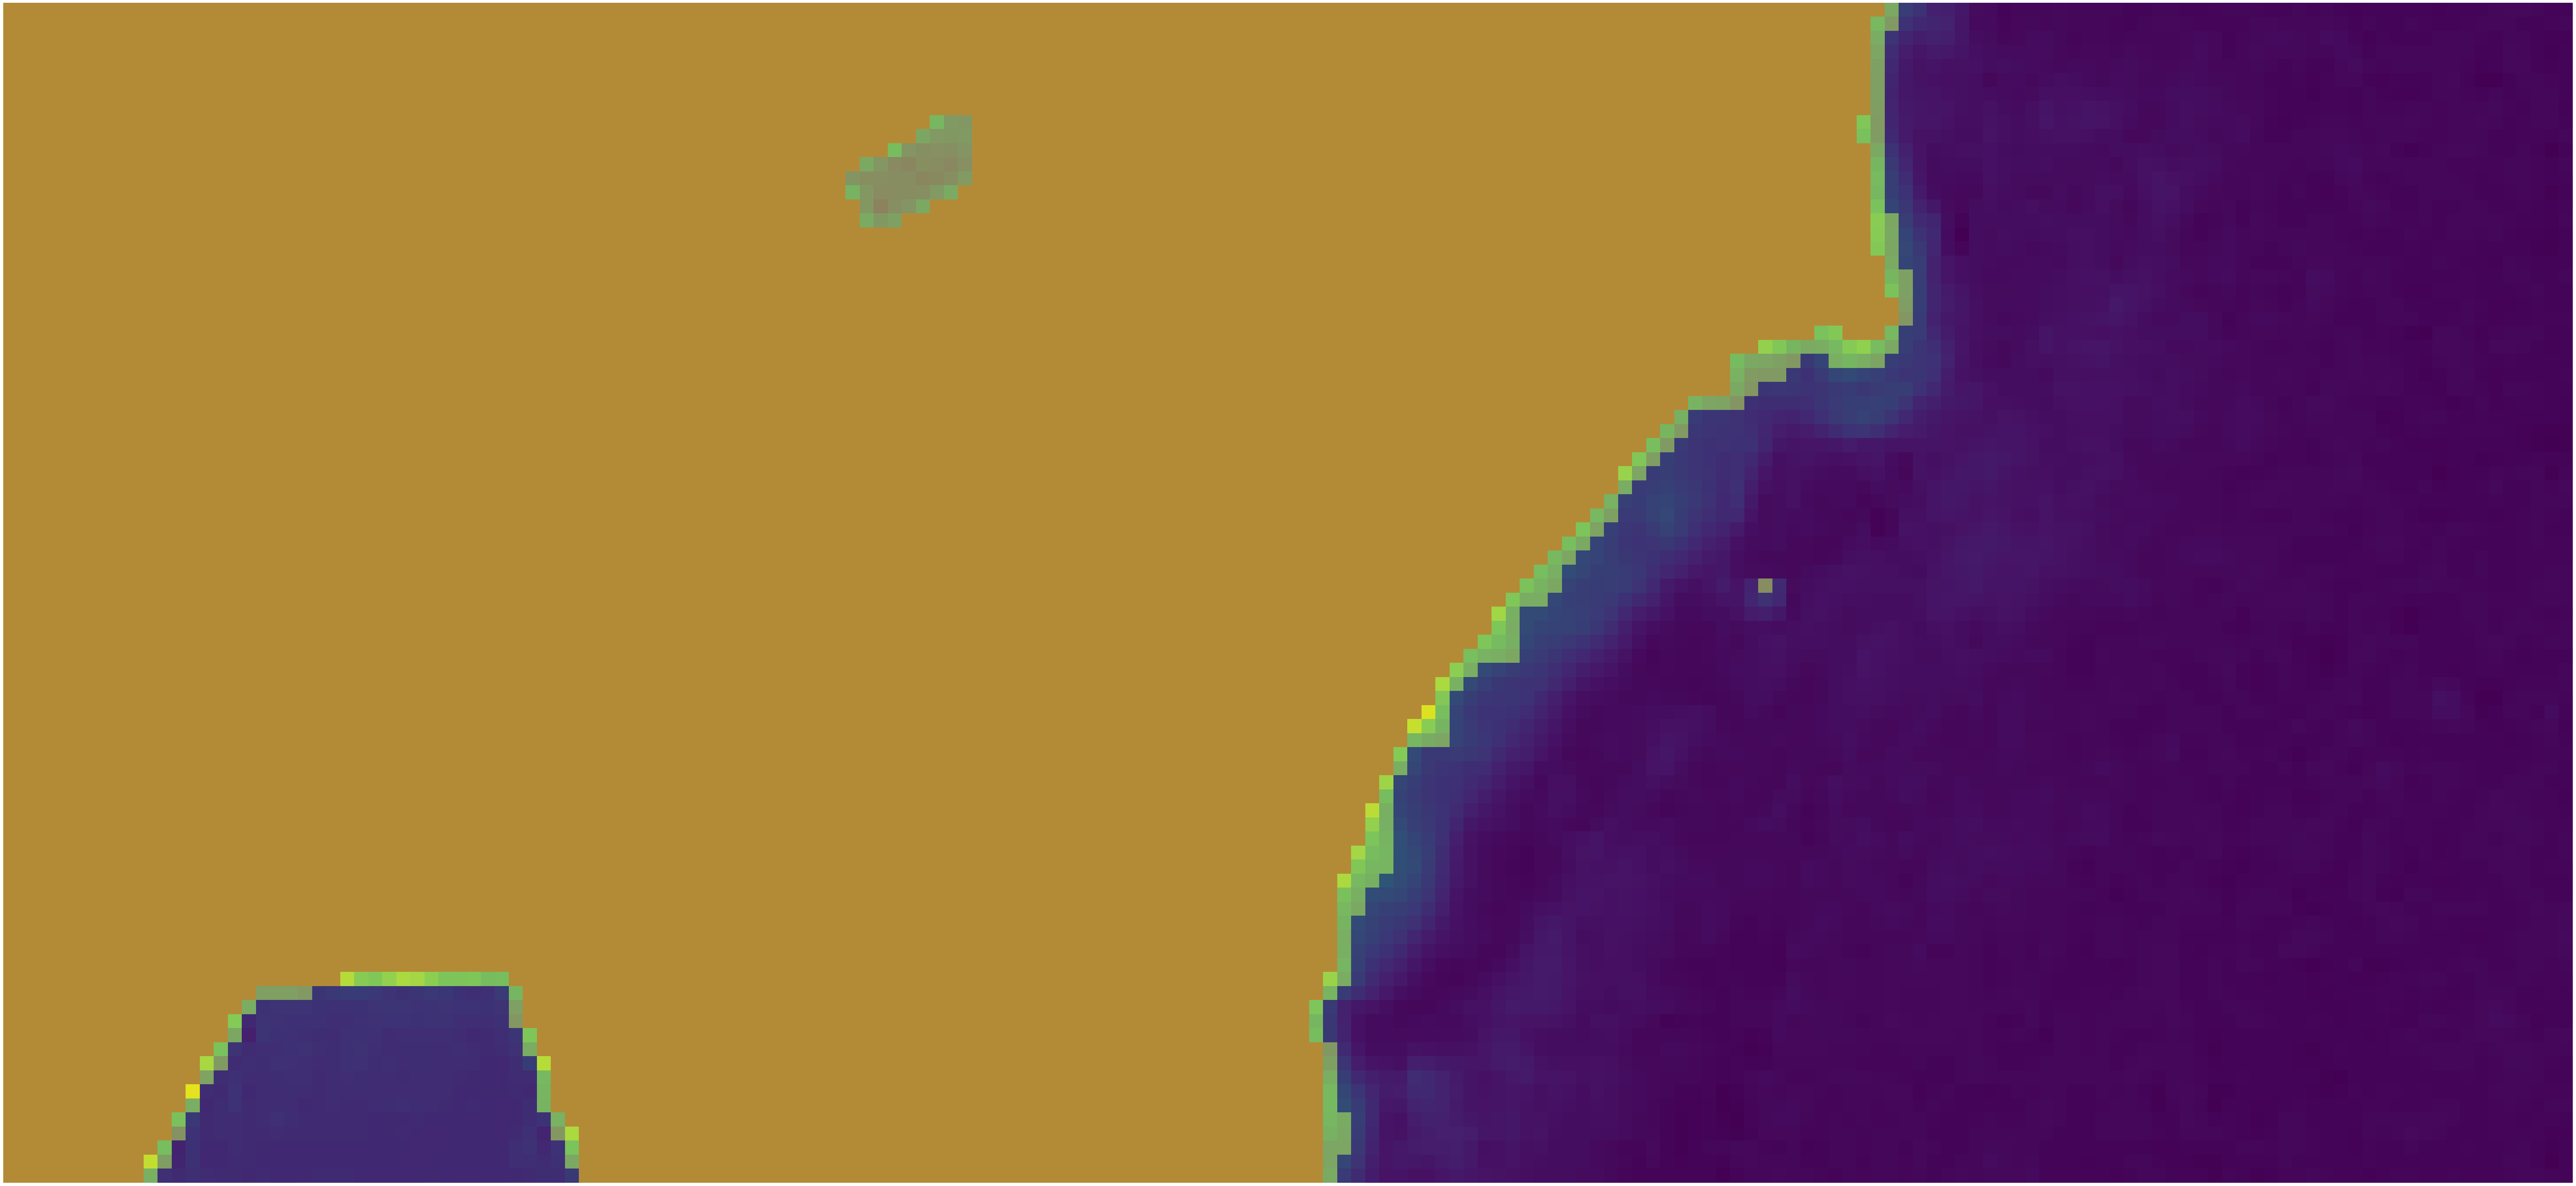

In [9]:
plt.figure(figsize = (100,100))
plt.subplot(121)
plt.imshow(img_labels0[:,:])
plt.subplot(122)
plt.imshow(result[:,:,1])
plt.imsave('spectral clustering.jpg',img_labels0)

fig, ax = plt.subplots(figsize = (100,100))
ax.imshow(result[:,:,1])
ax.imshow(img_labels0[:,:], alpha=0.4)
ax.set_axis_off()

In [10]:
label = tifffile.imread('data/label/2019_04_18_M_label.tif')
from sklearn.metrics import jaccard_score

flat_label = label.flatten()
flat_pred = img_labels0.flatten()

print(jaccard_score(flat_label, flat_pred))

0.0


Results are ok : we manage to find the plastic but also all the area just near the beach, when the sea is not deep.

# Planet image

Let's try now to find plastic targets with a higger spatial resolution but less spectral bands.

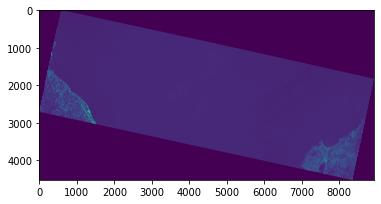

In [11]:
path = 'data/20190607_083535_103c_3B_AnalyticMS_SR.tif'
img = tifffile.imread(path)
plt.imshow(img[:,:,0])
img2 = img[990:1090,400:500]
tifffile.imsave('data/planet_image_crop.tif',img2)

With this image, it will be hard to have many land with plastic targets. So we will just take an image with the sea and plastic targets so as to have 2 clusters.

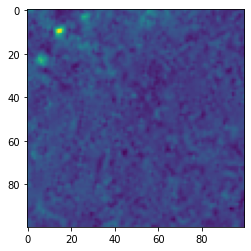

In [12]:
img2 = img[990:1090,400:500]
plt.imshow(img2[:,:,0])

Targets can be seen easily with the naked eye.
Let's zoom on the plastic targets : 

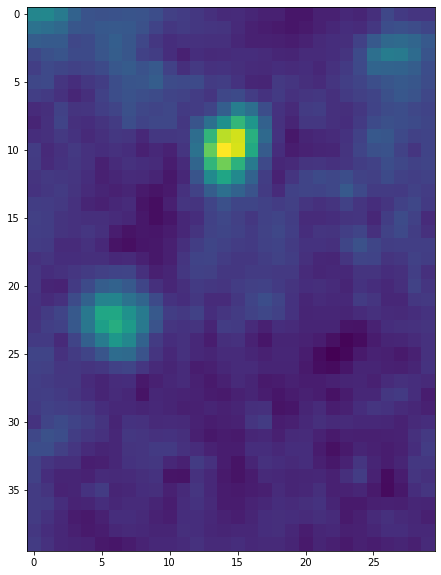

In [13]:
plt.figure(figsize = (10,10))
plt.imshow(img[990:1030,400:430,1])

Plastic targets may be easier to find as the resolution is higher. 

20.924781694440686
21.552857992386997
21.41165189236926
29.32504006817382


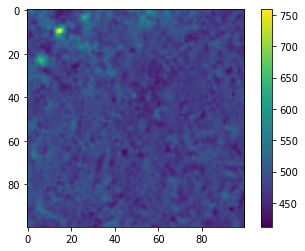

In [14]:
arrays_flat=np.array([img2[:,:,i].flatten() for i in range(img2.shape[2])])
X =(np.transpose(arrays_flat))
result = scale(img2)
plt.imshow(result[:,:,0])
plt.colorbar()

In [19]:
nb_cluster = 2
start = time.time()
clustering0 = SpectralClustering(n_clusters=nb_cluster, n_components = 10,random_state = 42,verbose = False ,assign_labels = 'kmeans', affinity = 'nearest_neighbors' ,  n_neighbors = 150).fit(X)
end = time.time()

print('time : ' , end - start)

time :  38.79452323913574


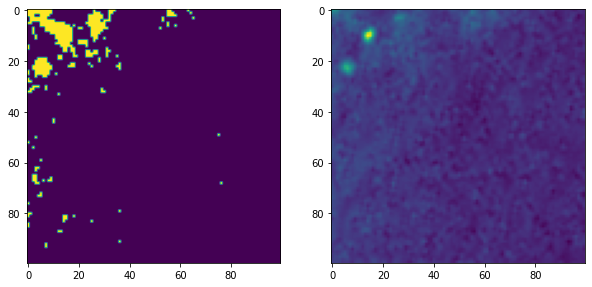

In [20]:
img_labels0 = clustering0.labels_.reshape(result[:,:,0].shape)
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(img_labels0)
plt.subplot(122)
plt.imshow(img2[:,:,1])

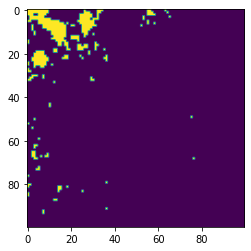

In [22]:
plt.imshow(img_labels0)
plt.savefig('planet.jpg')


We can clearly see that the targets are recovered but there are a lot of false alarms. These false alarms are can mostly be found in the top left corner of the image, where it is close from the coast : higher reflectivoty of the sea. 

Quick creation fo a label so as to quantify the results : 

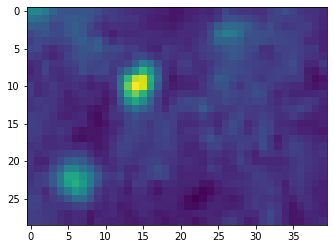

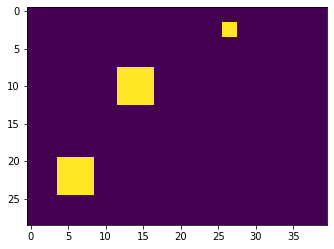

In [147]:
plt.figure(1)
plt.imshow(img2[0:29,:40,1])
label = np.zeros(img2.shape[:2])
label[8:13,12:17] = 1
label[20:25,4:9] = 1
label[2:4,26:28] = 1
plt.figure(2)
plt.imshow(label[0:29,:40])

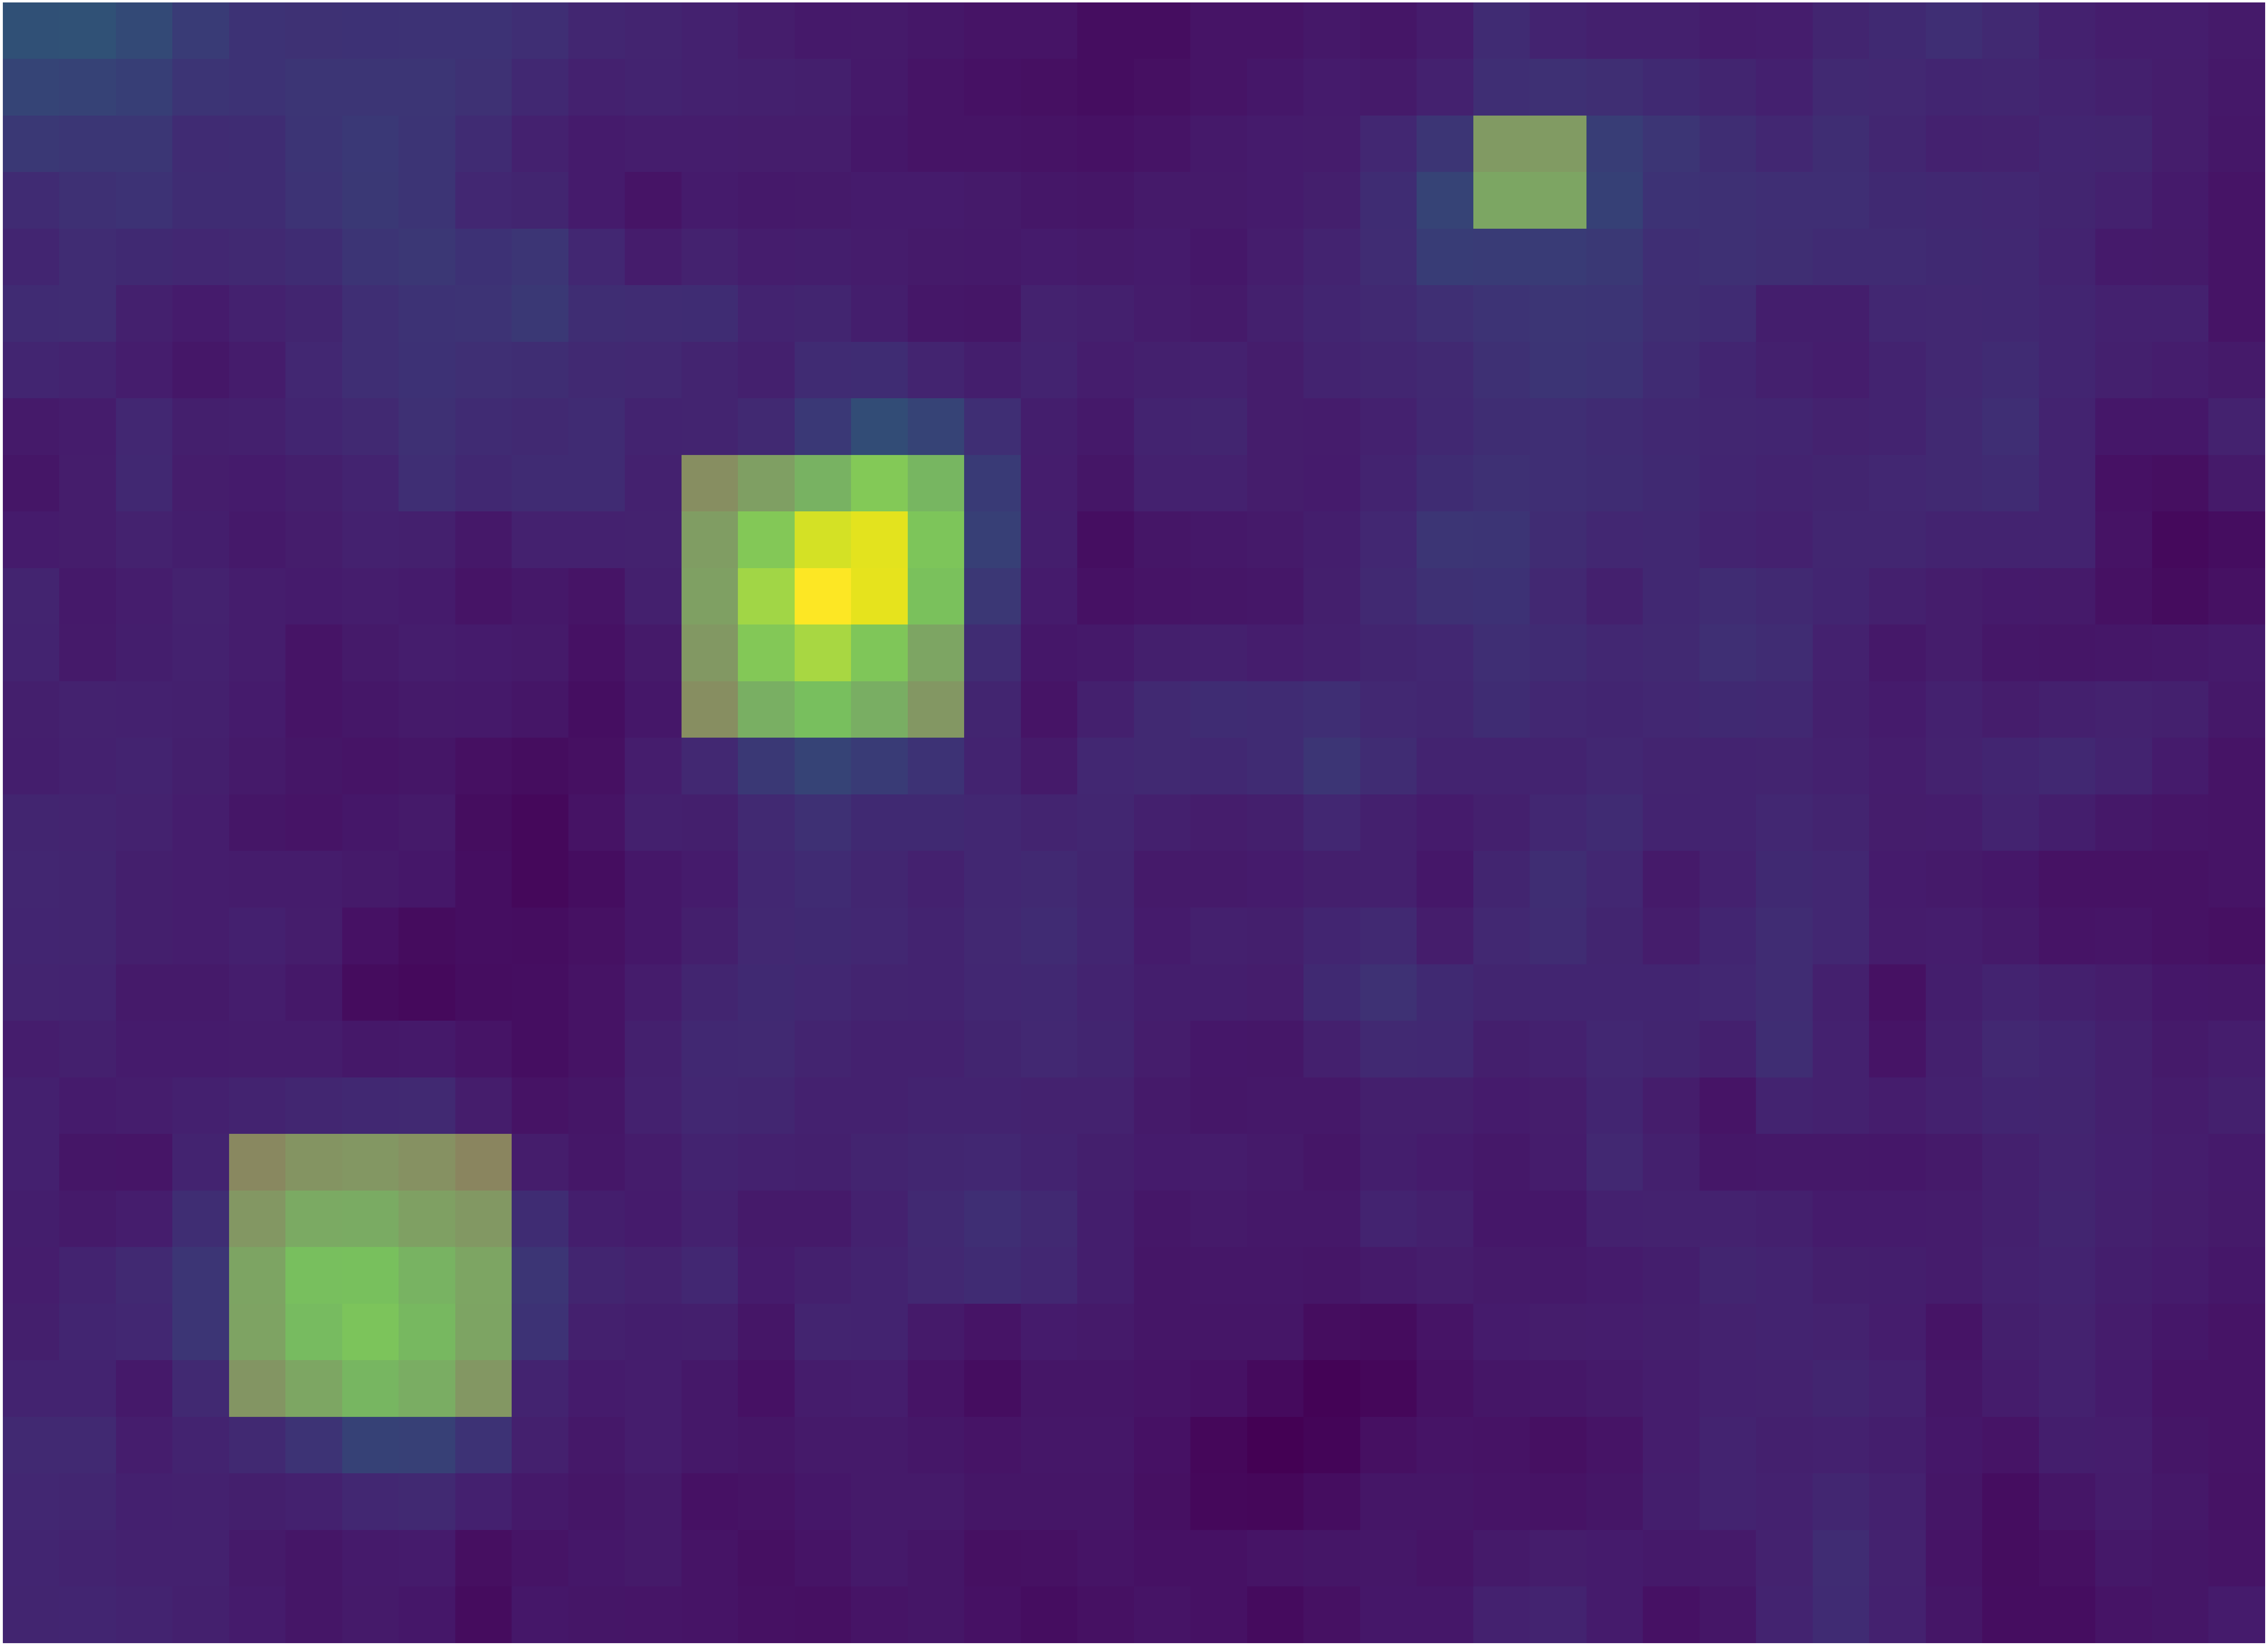

In [148]:
fig, ax = plt.subplots(figsize = (100,100))
ax.imshow(img2[0:29,:40,1])
ax.imshow(label[0:29,:40], alpha=0.4)
ax.set_axis_off()

In [151]:
tifffile.imsave('data/planet_label_crop.tif',label)

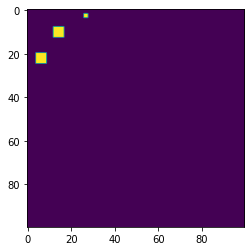

In [152]:
plt.imshow(label)

The jaccard score (intersection over union) has been chosen to quantify because it gives a good image of how well good claissfications have been made where the number of individuals is not balanced.

In [149]:
from sklearn.metrics import jaccard_score

flat_label = label.flatten()
flat_pred = img_labels0.flatten()

print(jaccard_score(flat_label, flat_pred))

0.22943722943722944
